In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Step 1 -- Posterior Interface

#### Here we determine how likely are a certain parameter values that we sampled using a log probability function.


## What “estimating parameters” actually means (Bayesian view)

In Bayesian inference, parameters are **not single numbers**.

They are **random variables**.

So the question is **not**:

> “What is the value of θ?”

It is:

> “How probable is each possible θ, given my data?”

That probability is exactly:

$
p(\theta \mid d)
$

So when you “estimate parameters”, you are really doing:

* Find **where** this distribution is large (best-fit)
* Find **how wide** it is (uncertainty)
* Find **how skewed / degenerate** it is

You cannot get any of that without knowing
**how probable a given θ is**.

---

## Why the sampler needs `log_prob(θ)`

An MCMC sampler does **not** solve equations.
It does **not** invert models.
It does **not** compute derivatives.

It does only one thing, over and over:

> Compare **two sets of parameters** and decide which is more probable.

To do that, it needs a number that answers:

> “How good is this θ compared to that θ?”

That number is the **log posterior probability**.

---

## Why *log* probability, not probability?

Two reasons:

### 1. Numerical stability

Likelihoods in astrophysics are often like:
$
\exp(-10^5)
$

That underflows to zero.

But:
$
\log p \sim -10^5
$

is perfectly fine.

### 2. Acceptance only depends on ratios

MCMC never uses absolute probabilities.
It only uses differences:

$
\log p(\theta') - \log p(\theta)
$

So logs are natural.

---

## How this leads to parameter estimates

Once the sampler runs, you get **samples**:

```python
theta_1, theta_2, theta_3, ...
```

These samples are drawn from:

$
p(\theta \mid d)
$

Now parameter estimation is trivial:

* Best-fit → mean / median / MAP
* Error bars → percentiles
* Correlations → joint distributions

The sampler doesn’t “estimate parameters”.
**You do**, from the samples.

---

## Analogy (important)

Think of `log_prob(θ)` like **χ²**.

In least squares you do:

```python
chi2(theta)
```

and then minimize it.

Here you do:

```python
log_prob(theta)
```

and then **explore** it.

Difference:

| Least squares | MCMC                    |
| ------------- | ----------------------- |
| Find minimum  | Map full landscape      |
| Local info    | Global info             |
| One answer    | Distribution of answers |

---

## Very concrete example

Say you have one parameter: cluster temperature (T).

You don’t know:

* Is T = 4.5 keV plausible?
* Is T = 6.0 keV plausible?

So you compute:

```python
log_prob(4.5)
log_prob(6.0)
```

Whichever is higher is more plausible.

MCMC just automates this comparison **millions of times**, intelligently.

---

## The key sentence (remember this)

> **You don’t give MCMC the answer.
> You give it a way to score answers.**

That score *is* `log_prob`.

---

## Why this is unavoidable

If you refuse to compute `p(θ | d)`:

* You cannot get uncertainties
* You cannot marginalize
* You cannot see degeneracies
* You cannot do Bayesian inference

At that point, you’re back to least squares.

---



In [2]:
#### simplest posterior

def log_prob(theta):
    return -0.5*np.sum(theta**2)

theta = np.array([0.1, -0.2])
print(log_prob(theta))

-0.025000000000000005


In [3]:
#### adding a hard prior #####
#### goals: Can I write a function that takes theta and returns a number?
        #   Does it return -np.inf for invalid points? WHY?- WE WANT TO ASSIGN ZERO PROBABILITY TO INVALID POINTS
#           Does it not crash?
def log_prob(theta):
    x,y=theta
    if x<=0:
        return -np.inf   # hard prior
    return -0.5 * (x - 1.0)**2 - 0.5 * y**2

print(log_prob(np.array([1.0, 0.0])))   # valid
print(log_prob(np.array([0.1, 2.0])))   # valid
print(log_prob(np.array([-1.0, 0.0])))  # invalid
print(log_prob(np.array([0.0, 1.0])))   # invalid

-0.0
-2.4050000000000002
-inf
-inf


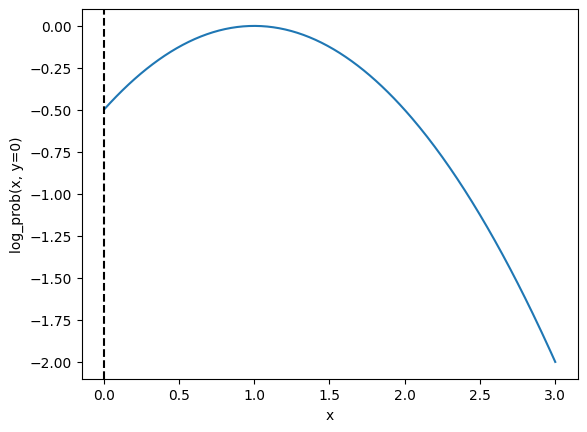

In [4]:
##### plotting the log-probability function for a set of parameters #####

import matplotlib.pyplot as plt

xs = np.linspace(-2, 3, 500)
ys = []

for x in xs:
    ys.append(log_prob(np.array([x, 0.0])))

plt.plot(xs, ys)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("x")
plt.ylabel("log_prob(x, y=0)")
plt.show()


Notice how the log probability vanishes for x<=0

# Step 2 -- The walkers (Ensemble)

#### The goal is to store multiple parameter vectors [theta1,theta2,..,], where, thetan=[param1,param2,param3].
#### Each vector is a walker. All walkers live in the same parameter space.

What must be stored (minimum)\
For an affine-invariant sampler, you need exactly two things:
1. The positions of the walkers
2. The log-probability at each position

In [5]:
n_walkers = 20
n_dim = 2

#walker positions
walkers=np.zeros((n_walkers,n_dim))

# log probabilities of each walker
log_probs=np.zeros(n_walkers)

Initializing the sampler

In [6]:
# initializing walkers near a guessed position
x0=np.array([1.0,0.0])

# sampling from a small gaussian ball around x0
walkers=x0+1e-2*np.random.randn(n_walkers,n_dim)

for i in range(n_walkers):
    log_probs[i]=log_prob(walkers[i])



## Why store logp separately?

Because calling `log_prob` is expensive.

Later:

* We reuse old values
* We only recompute when a proposal is accepted

This is a **huge speed win**.

---

## Minimal class (optional, but clean)


```python
class Ensemble:
    def __init__(self, walkers, logp):
        self.walkers = walkers
        self.logp = logp
```

But even this is optional.

---

## Important rules 

1. `n_walkers >= 2 * n_dim`
2. Walkers must **not all start at the same point**
3. Some walkers can start in low-probability regions — that’s okay

---

## Common mistakes

1. Using too few walkers
2. Forgetting to compute `logp` initially
3. Recomputing `log_prob` unnecessarily
4. Initializing all walkers identically





## Step 3 - The Stretch Factor


## Why do we need `z`?

In an affine-invariant sampler, a walker moves **along the line** connecting it to another walker.

`z` tells us **how far** along that line to go:

* `z < 1` → move closer
* `z > 1` → move farther away

To keep the algorithm *correct* (detailed balance), `z` **cannot** be uniform.

---

## The required distribution

For the Goodman–Weare stretch move:

$
g(z) \propto \frac{1}{\sqrt{z}}, \quad z \in \left[\frac{1}{a}, a\right]
$

* `a` is a fixed constant (usually `a = 2`)
* This choice ensures affine invariance


---


## Important intuition 

This distribution balances:

* **Small steps** → good acceptance
* **Large steps** → exploration

That balance is what makes the sampler:

* Fast
* Stable
* Tuning-free



In [7]:
def z_sample(a=2.0):
    u=np.random.rand()
    z=((a-1)*u+1)**2/a
    return z

zs = [z_sample() for _ in range(10000)]
print(min(zs), max(zs))                    # should be between 1/a and a i.e. 0.5 and 2.0 for a=2

0.5000994550821559 1.9997820428727484


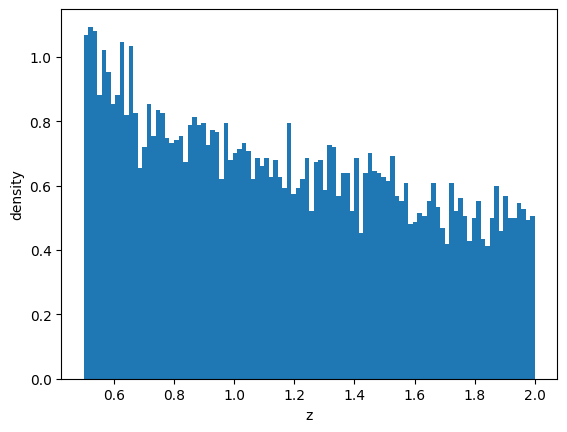

In [8]:
import matplotlib.pyplot as plt

plt.hist(zs, bins=100, density=True)
plt.xlabel("z")
plt.ylabel("density")
plt.show()


Notice how the distribution is not uniform even though the raw materials used were from a uniform distribution.


# **STEP 4 — Proposing a new walker position**

At this step, we finally answer:

> “Given two walkers, how do I propose a new position for one of them?”

---

## What objects do we already have?

From earlier steps, we have:

* An **ensemble of walkers**:

  ```python
  walkers.shape == (n_walkers, n_dim)
  ```
* A way to sample `z`:

  ```python
  z = sample_z(a)
  ```

Now we will use **two walkers**:

* `theta_i` → the walker we want to move
* `theta_j` → a reference walker (chosen randomly)

---

## The geometric idea (this is the heart of affine invariance)

Draw a straight line between the two walkers:

```
theta_j ---------------- theta_i
```

Now:

* Measure the vector from `j` to `i`
* Stretch or shrink that vector by a factor `z`
* Anchor the result at `theta_j`

That gives the proposal.

---

## The proposal formula (memorize this)


$\boxed{
\theta_i' = \theta_j + z  (\theta_i - \theta_j)
}$


That’s it.
This one line is the **entire proposal mechanism**.

---

## Why this is affine invariant (intuition)

* The move depends only on **relative positions**
* No absolute scale
* No coordinate axes
* No covariance matrices

If you stretch, rotate, or shear parameter space, this move behaves **exactly the same**.


Manually:

* `theta_i - theta_j = [1, 0]`
* Multiply by `z = 0.5` → `[0.5, 0]`
* Add to `theta_j` → `[1.5, 1.0]`

So the walker moved **halfway toward** `theta_j`.




In [9]:
def propose_stretch(theta_i, theta_j, z):
    """
    Propose a new position for theta_i using theta_j as reference.
    """
    return theta_j + z * (theta_i - theta_j)

In [10]:
####example#####
theta_i = np.array([2.0, 1.0])
theta_j = np.array([1.0, 1.0])

z = 0.5

theta_new = propose_stretch(theta_i, theta_j, z)
print(theta_new)

[1.5 1. ]




## What different `z` values do

| z value   | Effect          |
| --------- | --------------- |
| `z = 1`   | no move         |
| `z < 1`   | move closer     |
| `z > 1`   | move farther    |
| `z = 1/a` | max contraction |
| `z = a`   | max expansion   |

This is how exploration happens.

---


# **STEP 5 — Accept / Reject the proposal**

At this point we already have:

* Current walker position: `theta_i`
* Current log-probability: `logp_i`
* Proposed position: `theta_new`
* Proposed log-probability: `logp_new`
* Stretch factor: `z`
* Number of parameters: `n_dim`

Now we answer **one question only**:

> Do we keep the new position or not?

---

## The acceptance rule (the exact formula)

For the affine-invariant stretch move, compute:

$
\boxed{
\log \alpha=(n_{\text{dim}} - 1)\log z + \log p(\theta_{\text{new}}) - \log p(\theta_i)}
$

Then:

* Draw `u ~ Uniform(0, 1)`
* **Accept** if:
  
  $\log u < \log \alpha$
  
* Otherwise **reject**

That’s the entire decision process.

---

## Why this looks different from Metropolis

In standard Metropolis you’d have:

$
\log \alpha = \log p(\theta_{\text{new}}) - \log p(\theta_i)
$

Here we have an **extra term**:

$
(n_{\text{dim}} - 1)\log z
$

### Why?

Because the stretch proposal is **asymmetric**.
That term is the **Jacobian correction** that keeps detailed balance intact.

---



In [11]:
def accept_move(logp_old, logp_new, z, n_dim):
    log_alpha = (n_dim - 1) * np.log(z) + logp_new - logp_old
    return np.log(np.random.rand()) < log_alpha


z = 0.6
theta_new = propose_stretch(theta_i, theta_j, z)
logp_new = log_prob(theta_new)
logp_i = log_prob(theta_i)

if accept_move(logp_i, logp_new, z, n_dim):

    # update position and log-probability
    theta_i = theta_new
    logp_i = logp_new



## What happens with hard priors?

Suppose the proposal violates a hard prior:

```python
logp_new = -np.inf
```

Then:

```python
log_alpha = -np.inf
```

So the move is **always rejected**.

No special logic required.
This is why hard priors are so clean.

---

## Intuition check 

* If the proposal is **much better** → always accept
* If it’s **slightly worse** → sometimes accept
* If it’s **terrible** → reject
* If `z` stretches too aggressively → Jacobian penalizes it

This balance is what lets the sampler explore efficiently.

**You now understand the core of an affine-invariant sampler.**

Everything else is just looping and bookkeeping.

---



# **STEP 6 — Updating the full ensemble (A/B split)**

> How do we apply the single-walker move to *all* walkers without breaking correctness?

---

## Why we need to split the ensemble

If walkers used each other **while being updated**, detailed balance would break.

Solution (from Goodman & Weare):

* Split walkers into two disjoint groups:

  * Group **A**
  * Group **B**
* Update **A using B as references**
* Then update **B using A as references**

This guarantees correctness and parallel safety.

---

## What we already have

You already implemented:

* `sample_z(a)`
* `propose_stretch(theta_i, theta_j, z)`
* `accept_move(logp_old, logp_new, z, n_dim)`

Now we combine them.

---

## Step 6 logic (plain English)

1. Shuffle walker indices
2. Split indices into two halves: A and B
3. For each walker `i` in A:

   * Pick random `j` from B
   * Propose stretch move
   * Accept or reject
4. Repeat swapping A ↔ B

That’s one **ensemble step**.


In [12]:
def ensemble_step(walkers, logp, log_prob, a):
    n_walkers, n_dim = walkers.shape

    # shuffle and split
    idx = np.random.permutation(n_walkers)
    half = n_walkers // 2
    A = idx[:half]
    B = idx[half:]

    # update A using B
    for i in A:
        j = np.random.choice(B)

        z = z_sample(a)
        proposal = propose_stretch(walkers[i], walkers[j], z)
        logp_new = log_prob(proposal)

        if accept_move(logp[i], logp_new, z, n_dim):
            walkers[i] = proposal
            logp[i] = logp_new

    # update B using A
    for i in B:
        j = np.random.choice(A)

        z = z_sample(a)
        proposal = propose_stretch(walkers[i], walkers[j], z)
        logp_new = log_prob(proposal)

        if accept_move(logp[i], logp_new, z, n_dim):
            walkers[i] = proposal
            logp[i] = logp_new



# **STEP 7 — Running the sampler and collecting samples**

At this point you already have a **correct sampler**.
Now we turn it into something usable.

---

## What Step 7 does (plain English)

1. Repeatedly call `ensemble_step`
2. Save walker positions after each step
3. Return a chain you can analyze

That’s it.

---


In [13]:
def run_sampler(walkers, logp, log_prob, n_steps, a=2.0):
    """
    Run affine-invariant ensemble sampler.

    Parameters
    ----------
    walkers : ndarray, shape (n_walkers, n_dim)
    logp : ndarray, shape (n_walkers,)
    log_prob : callable
    n_steps : int
    a : float

    Returns
    -------
    chain : ndarray, shape (n_steps, n_walkers, n_dim)
    logp_chain : ndarray, shape (n_steps, n_walkers)
    """
    n_walkers, n_dim = walkers.shape

    chain = np.zeros((n_steps, n_walkers, n_dim))
    logp_chain = np.zeros((n_steps, n_walkers))

    for t in range(n_steps):
        ensemble_step(walkers, logp, log_prob, a)
        chain[t] = walkers
        logp_chain[t] = logp

    return chain, logp_chain


# initialize
n_walkers = 20
n_dim = 2
n_steps = 1000

walkers = np.ones((n_walkers, n_dim)) + 0.1 * np.random.randn(n_walkers, n_dim)
logp = np.array([log_prob(w) for w in walkers])

# run
chain, logp_chain = run_sampler(
    walkers, logp, log_prob, n_steps, a=2.0
)


In [14]:
# Flatten the chain to analyze samples
samples = chain.reshape(-1, n_dim)



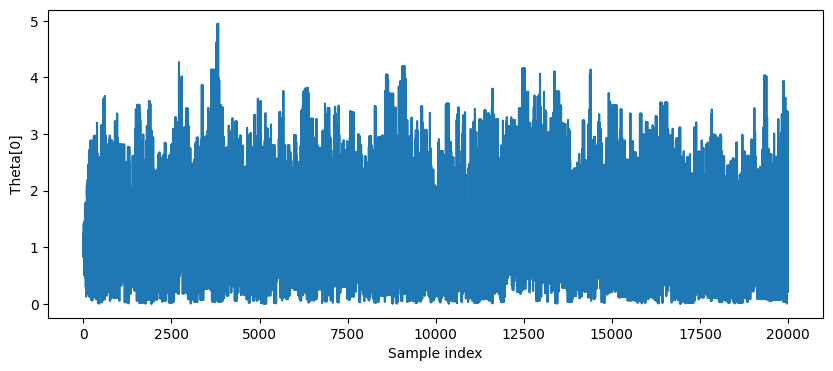

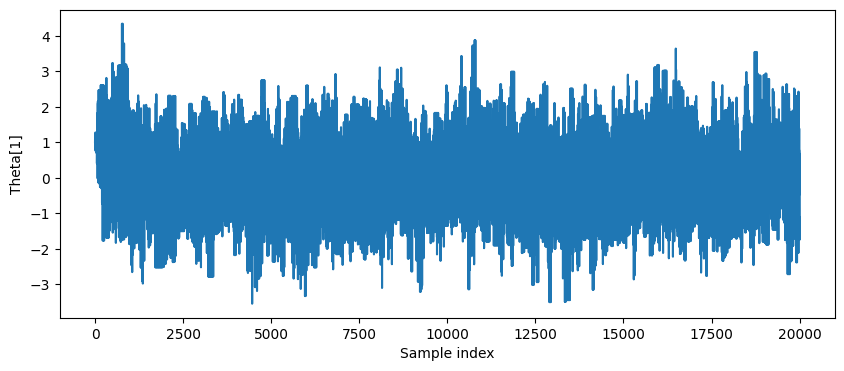

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(samples.shape[0]), samples[:, 0])
plt.xlabel("Sample index")
plt.ylabel("Theta[0]")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(np.arange(samples.shape[0]), samples[:, 1])
plt.xlabel("Sample index")
plt.ylabel("Theta[1]")
plt.show()

## What the output means

* `chain.shape == (n_steps, n_walkers, n_dim)`
* `chain[t, i]` = position of walker `i` at step `t`

To analyze, you usually **flatten** walkers:

```python
samples = chain.reshape(-1, n_dim)
```

Now:

* Mean → parameter estimate
* Std / percentiles → error bars
* Scatter → degeneracies

---

## Quick sanity check (important)

```python
print(samples.mean(axis=0))
print(samples.std(axis=0))
```

For a standard Gaussian, expect:

* Mean ≈ 0
* Std ≈ 1

---


## You now have the full picture

You’ve built:

1. Posterior interface
2. Ensemble representation
3. Stretch-factor sampling
4. Proposal mechanism
5. Acceptance rule
6. Ensemble update
7. End-to-end sampler

That is **everything emcee does at its core**.

### Full working example


## Step 0 — Freeze the philosophy (so we don’t accidentally betray it)

Before writing a single line, we pin down the contract:

* **Your sampler already exists**
  It knows nothing about data, models, or fitting.
  It only knows how to evolve walkers given `log_prob(x)`.

* **This new class is *not* a sampler**
  It is a *problem definition + glue layer*:

  * stores data
  * stores a model
  * defines `log_likelihood`, `log_prior`
  * exposes a `log_posterior(theta)` callable

If this class disappears tomorrow, your sampler should still be perfectly happy.

Think of it as a *Hamiltonian boundary condition*, not a new force.

---

## Step 1 — Decide what “fit a function” means (mathematically)

We’ll assume the simplest non-trivial case:

* Data:
  $
  (x_i, y_i, \sigma_i), \quad i = 1 \dots N
  $

* Model:
  $
  y = f(x \mid \theta)
  $

* Noise model:
  Independent Gaussian errors

This gives the log-likelihood:

$
\log \mathcal{L}(\theta)
= -\frac{1}{2} \sum_i
\left[
\frac{(y_i - f(x_i|\theta))^2}{\sigma_i^2}
\times \log(2\pi\sigma_i^2)
  \right]
  $


---

## Step 2 — Define the *minimum* interface of the fitting class

This class should answer exactly one question:

> “Given a parameter vector `theta`, what is `log_prob(theta)`?”

So the public surface is tiny:

* `__init__(data, model, log_prior)`
* `log_likelihood(theta)`
* `log_posterior(theta)` ← **this is what the sampler sees**

Nothing else is required *yet*.

---

## Step 3 — Write the bare-bones class (no sampler involved)

Here is a deliberately austere version:





In [16]:

class ParamEstimator:
    def __init__(self, x, y, yerr, model, log_prior):
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.yerr = np.asarray(yerr)

        self.model = model          # f(x, theta)
        self.log_prior = log_prior  # log p(theta)

    def log_likelihood(self, theta):
        "This function computes the log likelihood (p(y|theta)) given some data and model"
        y_model = self.model(self.x, theta)
        resid = self.y - y_model

        return -0.5 * np.sum(
            (resid / self.yerr) ** 2
            + np.log(2 * np.pi * self.yerr ** 2)
        )

    def log_posterior(self, theta):
        "This function computes the log posterior (p(theta|y)) given the prior and the likelihood"
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf

        return lp + self.log_likelihood(theta)




## Step 4 — Sanity-check with a trivial model

Before touching MCMC, we test deterministically.

Example: straight line
$
y = m x + b
$



In [17]:
def line_model(x, theta):
    m, b = theta
    return m * x + b

def flat_prior(theta):
    m, b = theta
    if -10 < m < 10 and -10 < b < 10:
        return 0.0
    return -np.inf


In [18]:
def data_generator(true_m, true_b, x, yerr):
    y = true_m * x + true_b
    y += yerr * np.random.randn(len(x))
    return y

x = np.linspace(0, 10, 50)
yerr = 1.0 + 0.5 * np.random.rand(len(x))
true_m = 3
true_b = 1.2
y = data_generator(true_m, true_b, x, yerr)

problem = ParamEstimator(
    x, y, yerr,
    model=line_model,
    log_prior=flat_prior
)

problem.log_posterior([2.5,1.2])     ### This function will give the highest log posterior value when we input parameters close to true_m and true_b


-188.45661766693638



If this number is finite and changes sensibly when you nudge parameters, the class is doing its job.

---

## Step 5 — Only now do we let the sampler in

Your sampler should see **exactly this**:




In [19]:
log_prob = problem.log_posterior   # Now the previos log_prob function is replaced with the log posterior function of our ParamEstimator class


In [20]:
def run_sampler(walkers, logp, log_prob, n_steps, a=2.0):
    """
    Run affine-invariant ensemble sampler.

    Parameters
    ----------
    walkers : ndarray, shape (n_walkers, n_dim)
    logp : ndarray, shape (n_walkers,)
    log_prob : callable
    n_steps : int
    a : float

    Returns
    -------
    chain : ndarray, shape (n_steps, n_walkers, n_dim)
    logp_chain : ndarray, shape (n_steps, n_walkers)
    """
    n_walkers, n_dim = walkers.shape

    chain = np.zeros((n_steps, n_walkers, n_dim))
    logp_chain = np.zeros((n_steps, n_walkers))

    for t in range(n_steps):
        ensemble_step(walkers, logp, log_prob, a)
        chain[t] = walkers
        logp_chain[t] = logp

    return chain, logp_chain


class MCMCfit:
    def __init__(self, estimator):
        """
        estimator : ParamEstimator
        """
        self.estimator = estimator

        self.chain = None
        self.logp_chain = None
        self.samples = None

    def sample(self, n_walkers, n_dim, n_steps, a=2.0, init_scale=1e-2):
        # initialize walkers
        walkers = init_scale * np.random.randn(n_walkers, n_dim)
        logp = np.array([
            self.estimator.log_posterior(w) for w in walkers
        ])

        # run sampler
        self.chain, self.logp_chain = run_sampler(
            walkers,
            logp,
            self.estimator.log_posterior,
            n_steps,
            a=a
        )

    def extract_samples(self, burnin=0):
        if self.chain is None:
            raise RuntimeError("You must run sample() first")

        samples = self.chain[burnin:]
        n_steps, n_walkers, n_dim = samples.shape

        self.samples = samples.reshape(n_steps * n_walkers, n_dim)
        return self.samples

    def mean(self):
        return self.samples.mean(axis=0)

    def median(self):
        return np.median(self.samples, axis=0)

    def credible_interval(self, level=0.68):
        lo = (1 - level) / 2
        hi = 1 - lo
        return np.quantile(self.samples, [lo, hi], axis=0)

    def map(self):
        logp = np.array([
            self.estimator.log_posterior(s) for s in self.samples
        ])
        return self.samples[np.argmax(logp)]


In [21]:
estimator = ParamEstimator(
    x, y, yerr,
    model=line_model,
    log_prior=flat_prior
)

fit = MCMCfit(estimator)

fit.sample(
    n_walkers=20,
    n_steps=3000,
    n_dim=2
)

fit.extract_samples(burnin=200)

fit.mean()
fit.credible_interval()
fit.map()


array([2.93573463, 1.19931466])

In [22]:
fit.credible_interval(),fit.mean(), fit.map()


(array([[2.87994149, 0.86368883],
        [2.99446153, 1.52392951]]),
 array([2.93722442, 1.19295186]),
 array([2.93573463, 1.19931466]))

## Some plotting codes

Removed no burn in


(-0.37057722311297825, 2.631570465422152)

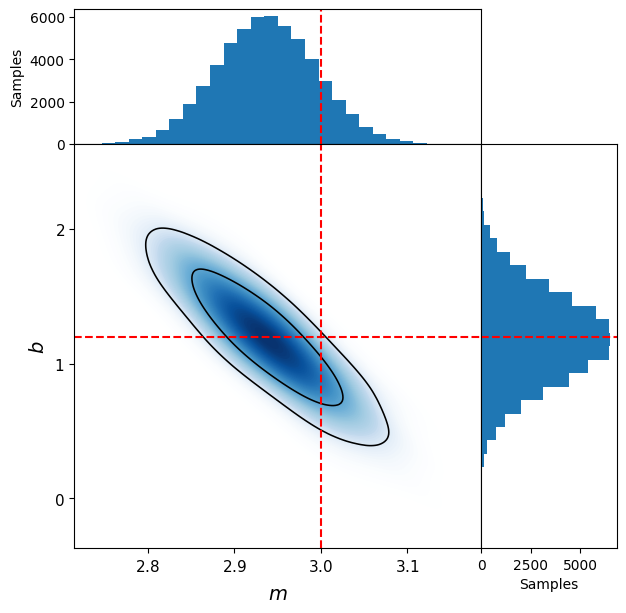

<Figure size 400x300 with 0 Axes>

In [23]:

import matplotlib.gridspec as gridspec
import getdist
from getdist import plots, MCSamples

parameters = fit.samples
grid = gridspec.GridSpec(2, 2, wspace=0.0, hspace=0.0, width_ratios=[3,1], height_ratios=[1,3])
plt.figure(figsize=(7,7))
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[0,1])  # unused
fig = ax2.figure
fig.delaxes(ax2)
ax3 = plt.subplot(grid[1,0])
ax4 = plt.subplot(grid[1,1])

ax1.hist(parameters[:,0], bins=30)
ax1.axvline(true_m, color='r', linestyle='--')
ax1.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax1.set_xlabel("")
ax1.set_ylabel("Samples")

names = ['m', 'b']
samples = MCSamples(samples=parameters, names=names, labels=names, settings={"smooth_scale_2D": 0.5})
g = plots.get_single_plotter(width_inch=4)
g.plot_2d([samples], "m", "b", shaded=True, ax=ax3)
ax3.axvline(true_m, color='r', linestyle='--')
ax3.axhline(true_b, color='r', linestyle='--')

ax4.hist(parameters[:,1], bins=30, orientation='horizontal')
ax4.tick_params(axis="y", which="both", left=False, labelleft=False)
ax4.set_ylabel("")
ax4.set_xlabel("Samples")
ax4.axhline(true_b, color='r', linestyle='--')
plt.tight_layout()
# ...existing code...
# Match axes across ax1 / ax3 / ax4
xmin, xmax = parameters[:, 0].min(), parameters[:, 0].max()
ymin, ymax = parameters[:, 1].min(), parameters[:, 1].max()

ax1.set_xlim(xmin, xmax)
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(ymin, ymax)
ax4.set_ylim(ymin, ymax)


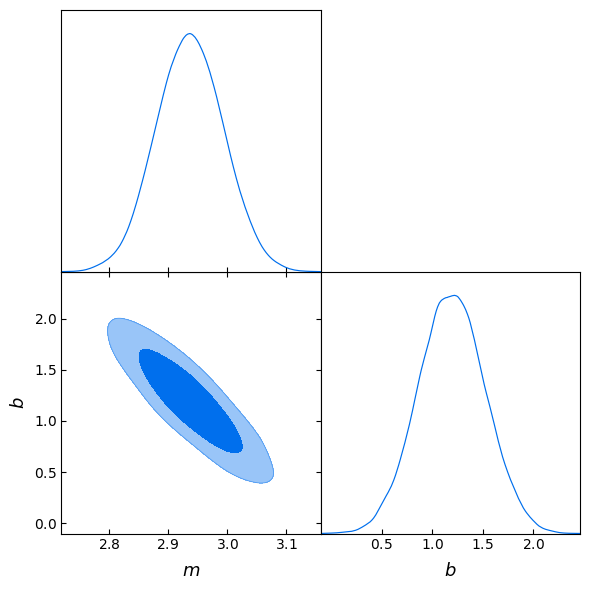

In [24]:
g = plots.get_subplot_plotter(subplot_size=3)
g.triangle_plot([samples], filled=True)


Text(0, 0.5, 'y')

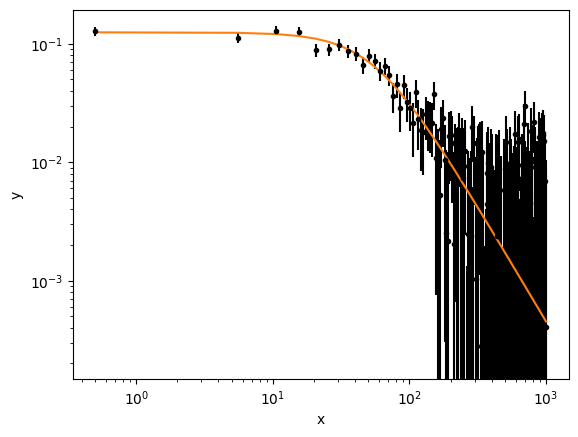

In [41]:
import walker as wk


def beta_model(x, theta):
    n0, rc, beta = theta
    return n0 * (1.0 + (x / rc)**2)**(-1.5 * beta)


def log_prior(theta):
    n0, rc, beta = theta
    if 0 < n0 < 1 and 1 < rc < 500 and 0 < beta < 2:
        return 0.0
    return -np.inf


rng = np.random.default_rng(42)

x = np.linspace(0.5, 1000, 200)
theta_true = [0.125, 56.0, 0.65]

y_true = beta_model(x, theta_true)
yerr = 0.01 * y_true + 1e-2
y = y_true + rng.normal(0, yerr)

plt.errorbar(x, y, yerr=yerr, fmt=".k", label="data")
plt.plot(x, y_true, color="C1", label="true model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("x")
plt.ylabel("y")

In [42]:

from walker import Log, Identity, CompositeTransform

transform = CompositeTransform([
    Log(),        # n0 > 0
    Log(),        # rc > 0
    Identity(),   # beta unconstrained
])

estimator = wk.ParamEstimator(
    x, y, yerr,
    model=beta_model,
    log_prior=log_prior,
    transform=transform
)

fit = wk.MCMCfit(estimator)
fit.sample(
    n_walkers=30,
    n_steps=3000,
    progress=True
)

print("Mean:", fit.mean(burnin=1000))
print("Median:", fit.median(burnin=1000))
print("MAP:", fit.map(burnin=1000))
print("Actual:", theta_true)


Sampling:   0%|          | 0/3000 [00:00<?, ?step/s]/Users/alpish/MCMC/WALKER/walker.py:125: RuntimeWarning: invalid value encountered in scalar subtract
  log_alpha = (n_dim - 1) * log_z + logp_new - logp[ii]
/Users/alpish/MCMC/WALKER/walker.py:143: RuntimeWarning: invalid value encountered in scalar subtract
  log_alpha = (n_dim - 1) * log_z + logp_new - logp[ii]
Sampling: 100%|██████████| 3000/3000 [00:01<00:00, 1775.34step/s]


Mean: [ 0.11931357 68.29685202  0.76459409]
Median: [ 0.11921722 66.80626515  0.74052503]
MAP: [ 0.12020483 63.65668594  0.70637201]
Actual: [0.125, 56.0, 0.65]


Removed no burn in


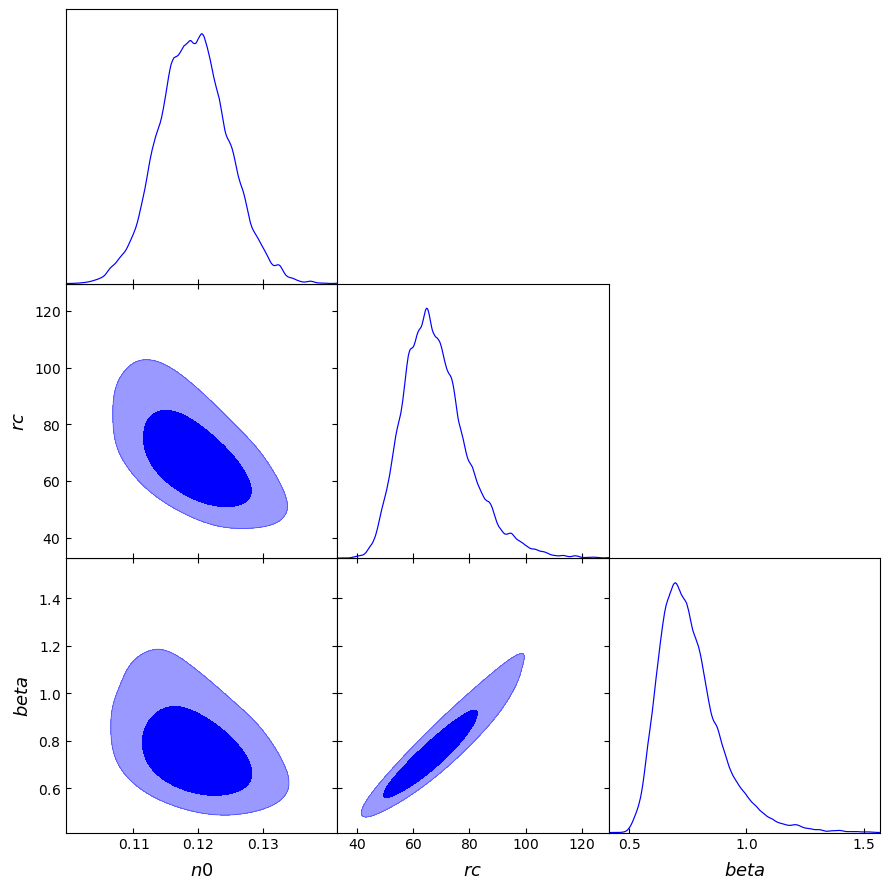

In [46]:
samples=fit._extract_samples(burnin=1000, thin=2, physical=True)
gplot=MCSamples(samples=samples, names=['n0', 'rc', 'beta'], labels=['n0', 'rc', 'beta'], 
                   settings={"smooth_scale_2D": 0.6})
g = plots.get_subplot_plotter(subplot_size=3)
g.triangle_plot([gplot], filled=True,contour_colors=['blue'])
